# A/A/B Testing in an Online Grocery Store

I work at a startup that sells grocery products. We need to understand how users behave in our mobile application. In this project, we will analyze the sales funnel. We will find out how users move toward making a purchase. How many users complete a purchase, and how many “drop off” at earlier stages? At which specific steps does this happen?

After that, we will analyze the results of an A/A/B experiment. The designers wanted to change the fonts in our application, but the managers were concerned that users might find the new fonts unfamiliar. It was decided to rely on the results of an A/A/B test. Users were divided into three groups: two control groups with the old fonts and one experimental group with the new fonts. We will determine which font performs better.

Creating two A groups instead of one has certain advantages. If the two control groups show similar results, we can be confident in the accuracy of the experiment. If there are significant differences between them, it may help identify factors that caused distortions in the results. Comparing the control groups also helps us understand how much time and data will be required for future tests.

**Project Goal**

The main goal of the project is to improve purchase conversion in the mobile application for selling grocery products.

**Tasks**

- Step 1. Open the data file and review general information

Study the general information about the file, including the number of events, users, data types, etc. View the first few rows to ensure that the data is correct.

- Step 2. Data preprocessing

Rename the columns to make them more convenient. Check for missing values and data types. Correct them if necessary. Add a column with date and time, as well as a separate column for the date.

- Step 3. Data exploration and validation

Determine how many events are recorded in the log, how many users are in the dataset, and the average number of events per user. Analyze how the amount of data changes over time. Check whether the data covers the entire period.

- Step 4. Funnel analysis

Calculate how many users performed each event. Determine the order in which events occur. Calculate the share of users who move to the next step of the funnel. Identify the stage where the largest number of users drop off.

- Step 5. Experiment analysis

Compare the number of users in each experimental group. Check whether statistical criteria detect differences between the control groups. Compare the results of the experimental group with the control group for each event. Draw conclusions from the experiment.

**Import necessary libraries:**

In [5]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
from plotly import graph_objects as go

from scipy import stats as st

import math as mth

## Opening the Data File and Reviewing General Information

In [6]:
df = pd.read_csv('/Users/dianasalnikova/Downloads/logs_exp.csv', sep='\t')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [8]:
df.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [9]:
df.duplicated().sum()

413

**Conclusion:** Based on the obtained data, we can see that the table contains 244,126 rows, there are no missing values, and the data types are correctly specified. It is necessary to remove duplicates and convert the column names to lowercase for convenience.

## Data Preprocessing
- Rename the columns to more convenient names;
- Check for missing values and data types and correct them if necessary;
- Add a date and time column, as well as a separate date column.

Renaming the columns:

In [10]:
df = df.rename(columns={'EventName':'event_name', 'DeviceIDHash':'device_id_hash', 'EventTimestamp':'event_timestamp', 'ExpId':'exp_id'})
df.columns

Index(['event_name', 'device_id_hash', 'event_timestamp', 'exp_id'], dtype='object')

Removing duplicates:

In [11]:
df = df.drop_duplicates().reset_index(drop=True)

In [12]:
df.duplicated().sum()

0

Converting the data type of "event_timestamp" to datetime:

In [13]:
df['event_timestamp'] = pd.to_datetime(df['event_timestamp'], unit='s')

Adding a separate date column:

In [14]:
df['date'] = pd.to_datetime(df['event_timestamp'].dt.date)

In [15]:
df.head()

,event_name,device_id_hash,event_timestamp,exp_id,date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


We group users by experimental groups and apply the nunique() method, which shows the number of groups per user, then reset the index:

In [16]:
users_in_both_groups = df.groupby('device_id_hash')['exp_id'].nunique().reset_index()

We only keep users who belong to more than one group:

In [17]:
users_in_both_groups = users_in_both_groups[users_in_both_groups['exp_id'] > 1]

users_in_both_groups

,device_id_hash,exp_id


## Data Exploration and Validation
- How many total events are recorded in the log?
- How many users are in the dataset?
- What is the average number of events per user?
- For what period do we have data? Let’s find the minimum and maximum dates.
We will analyze how the amount of data changes over time:
build a bar chart showing the number of events over time by group.
We need to understand whether we can be confident that the data is complete for the entire period. Technically, events from previous days may be logged with a delay for some users — this may “distort” the data.
We will determine from which point the data is complete and discard older records. What is the actual time period covered by reliable data?
- How many events and users did we lose after filtering out the older data?
- Verify that we have users in all three experimental groups.

### Total number of events in the log:

In [14]:
df.shape[0]

243713

Let’s check how many unique events there are:

In [15]:
df.event_name.nunique()

5

### The number of users in the log:

In [18]:
df.device_id_hash.nunique()

7551

### The average number of events per user:

In [19]:
f'On average, each user generated {round(df.shape[0] / df.device_id_hash.nunique())} events'

'On average, each user generated 32 events'

### Time period covered by the data

In [20]:
df.date.agg(['min', 'max'])

min   2019-07-25
max   2019-08-07
Name: date, dtype: datetime64[ns]

Our dataset covers the period from July 25 to August 7, 2019.

How the amount of data changes over time:

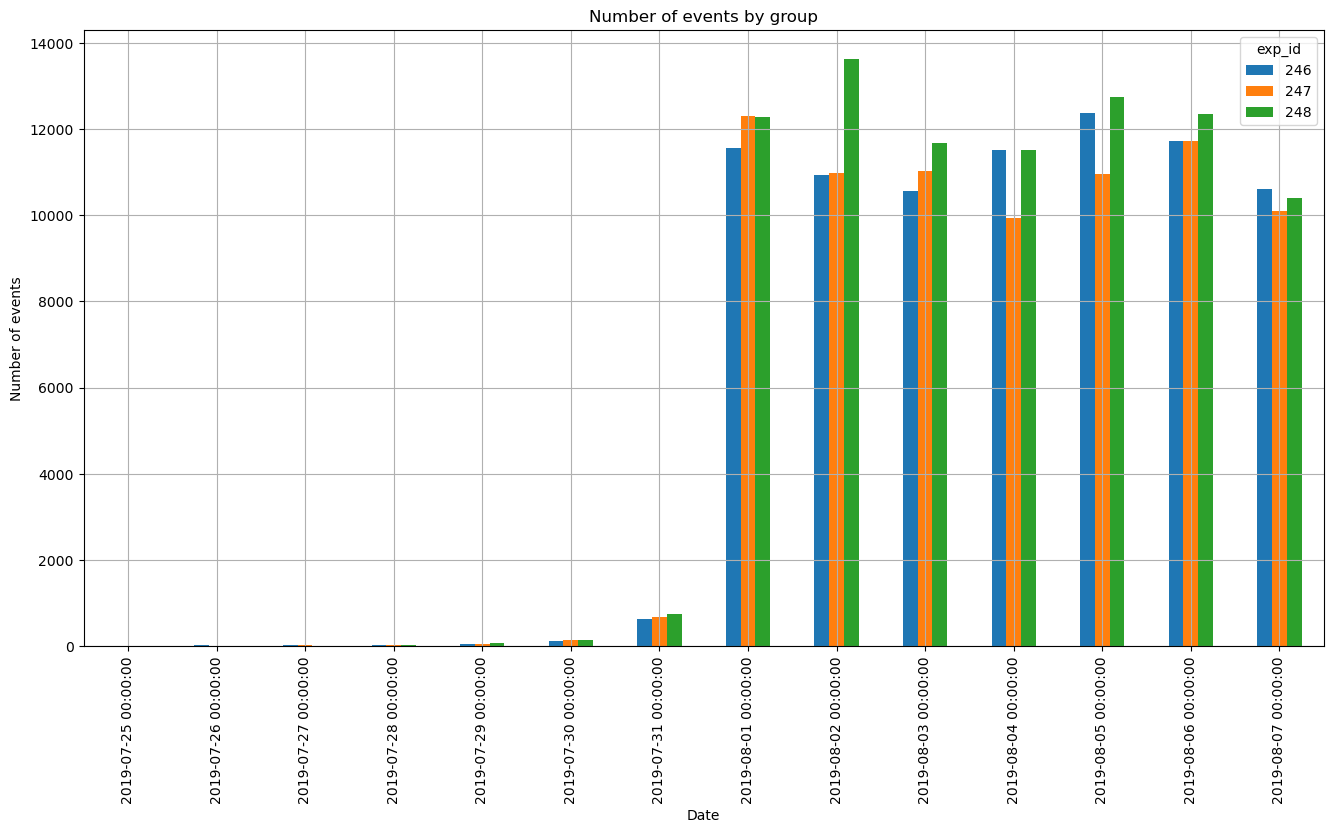

In [21]:
df.pivot_table(index='date', 
               columns='exp_id', 
               values='event_name', 
               aggfunc='count').plot(kind='bar', 
                                     title='Number of events by group',
                                     xlabel='Date', 
                                     ylabel='Number of events',
                                     grid=True,
                                     figsize=(16,8))

None

From the chart, we can see that before August 1 there were very few events. It can be assumed that this is a startup that launched on August 1, or there may be a technical issue in the data. For further analysis, we will use data from August 1 to August 7.

Filtering the data:

In [22]:
df_new = df.query('date >= "2019-08-01"')

### How many events and users did we lose after discarding older data?

Let’s calculate the number of events excluded by the filter:

In [23]:
df.shape[0] - df_new.shape[0]

2826

In [25]:
'Percentage of events excluded by the filter: {:.1%}'.format((df.shape[0] - df_new.shape[0])/df.shape[0])

'Percentage of events excluded by the filter: 1.2%'

Number of unique users excluded by the filter:

In [23]:
df.device_id_hash.nunique() - df_new.device_id_hash.nunique()

17

In [26]:
'Number of users excluded by the filter (relative) {:.1%}'.format((df.device_id_hash.nunique() - df_new.device_id_hash.nunique())/df.device_id_hash.nunique())

'Number of users excluded by the filter (relative) 0.2%'

### Let’s verify that users from all three experimental groups are present in the filtered data:

In [25]:
df_new.groupby('exp_id')['device_id_hash'].nunique().reset_index()

,exp_id,device_id_hash
0,246,2484
1,247,2513
2,248,2537


**Conclusion:** The data exploration and validation stage is complete. We examined the number of events and users in the log, filtered the dataset to include the period from August 1 to August 7, 2019, calculated the data loss in terms of both events and users, and verified that users from all three experimental groups are present.

## Funnel Analysis
- Let’s examine which events are present in the logs and how frequently they occur. Sort the events by frequency.
- Calculate how many users performed each event. Sort events by the number of users. Compute the share of users who performed each event at least once.
- Determine the order in which events occur. Do they form a sequential chain? Identify which events should be included in the funnel calculation.
- For the event funnel, calculate the share of users who move to the next step (relative to the number of users at the previous step).                                                     
    For example, for the sequence A → B → C, calculate: 
    - the ratio of users with event B to users with event A, 
    - and the ratio of users with event C to users with event B.

- At which step do we lose the largest number of users?
- What share of users reaches the payment stage from the first event?

### Examine which events are present in the logs and sort them by frequency

Let’s look at the count of each unique event:

In [27]:
df_new.event_name.value_counts()

MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: event_name, dtype: int64

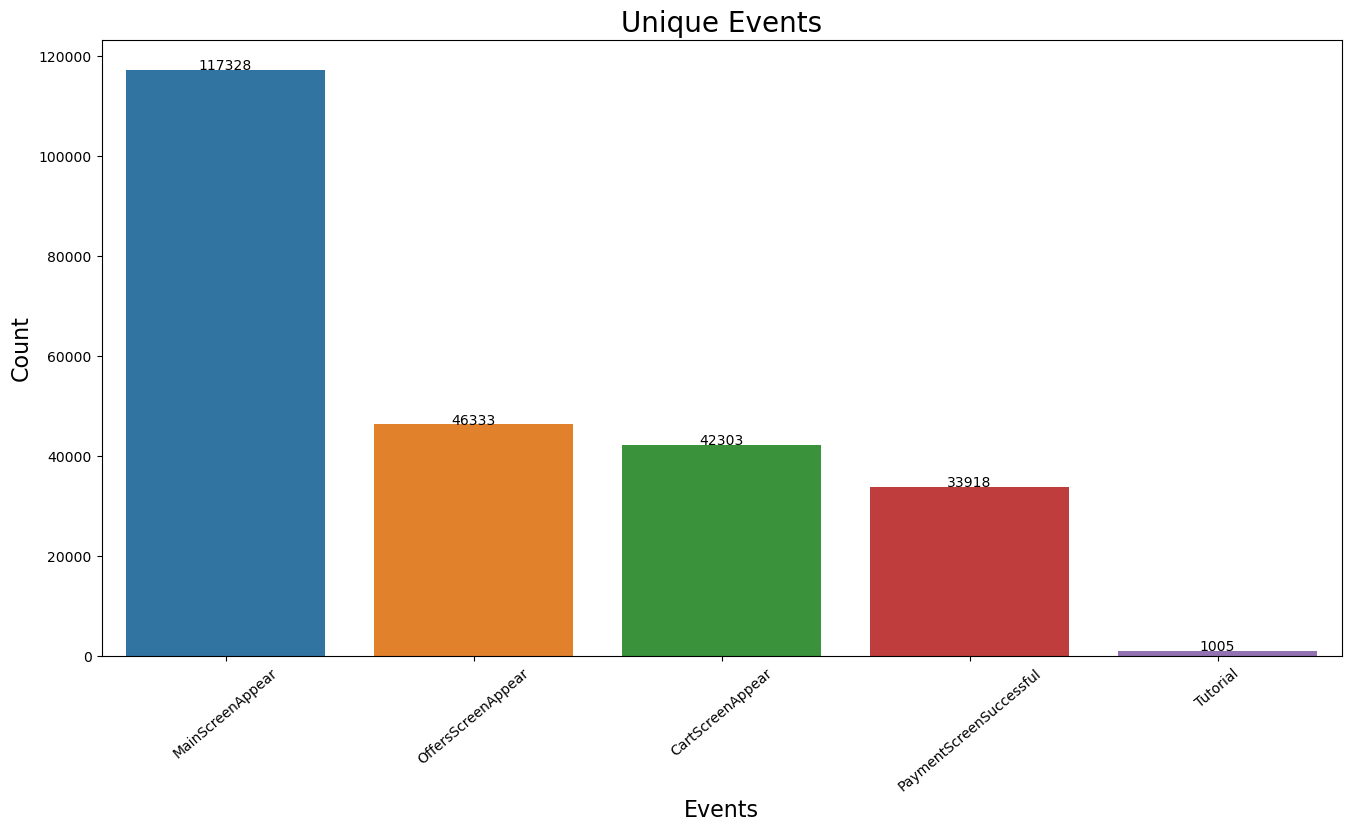

In [28]:
x=df_new.event_name.value_counts().index
y=df_new.event_name.value_counts().values

plt.figure(figsize=(16,8))

ax = sns.barplot(x=x, y=y)

ax.set_xlabel('Events', fontsize=16)
ax.set_ylabel('Count', fontsize=16)
ax.set_title('Unique Events', fontsize=20)

plt.xticks(rotation=40, fontsize=10)

for i in range(len(x)):
    plt.text(i, y[i] + 1, str(y[i]), ha='center')

As we can see from the chart, the most frequent event is the appearance on the main screen. Then come the offers screen and the cart screen appearance (with almost the same frequency), followed by the successful payment screen. The tutorial was opened only 1,005 times.

### Number of users that have completed each of the actions (events)
We will sort the events by the number of users and calculate the share of users who completed each action at least once.

In [29]:
users = df_new.groupby('event_name')['device_id_hash'].nunique().reset_index().sort_values('device_id_hash', ascending=False)
users.rename(columns={'device_id_hash':'cnt_users'}, inplace=True)
users['ratio'] = (users.cnt_users / df.device_id_hash.nunique() * 100).round(2)
users

,event_name,cnt_users,ratio
1,MainScreenAppear,7419,98.25
2,OffersScreenAppear,4593,60.83
0,CartScreenAppear,3734,49.45
3,PaymentScreenSuccessful,3539,46.87
4,Tutorial,840,11.12


**Conclusion:** 98% of users visited the main screen, 61% viewed the offers screen, about half of users viewed the cart, 47% successfully completed a payment, and 11% opened the tutorial.

### Let’s assume the order in which events occur
Do all events form a logical sequential chain? Should all of them be included in the funnel calculation?

Not all events form a logical sequence. The only event that does not belong to the main purchasing flow is “Tutorial.” 

The main funnel sequence is: **Main Screen → Offers Screen → Cart → Successful Payment.**

Reading the tutorial is not required to complete a purchase, so we exclude this event from the funnel analysis.

### The share of users who move to the next step of the funnel

In [30]:
users = users.drop(4).reset_index(drop=True)

To build the funnel, let’s create an additional column:

In [31]:
users['ratio_step'] = round(users.cnt_users / users.cnt_users.shift(1) *100, 2).fillna(0)
users

,event_name,cnt_users,ratio,ratio_step
0,MainScreenAppear,7419,98.25,0.00
1,OffersScreenAppear,4593,60.83,61.91
2,CartScreenAppear,3734,49.45,81.30
3,PaymentScreenSuccessful,3539,46.87,94.78


The "ratio_step" column shows the percentage of users who moved from the previous step to the next one. Now let’s build the sales funnel:

In [33]:
fig = go.Figure(go.Funnel(
    y = users.event_name,
    x = users.cnt_users,
    textposition = 'inside',
    textinfo = 'value+percent previous',
    opacity = 0.65,
    marker = {'color': ['red', 'blue', 'green', 'brown']}))

fig.update_layout(title="Event Funnel")


fig.show()

### At which step do we lose the largest number of users?

Approximately 40% of users drop off when moving from the main screen to the offers catalog. This is the stage where the largest user loss occurs. From the offers screen to the cart, 81% of users proceed further, and of those, nearly 95% complete the purchase.

### The share of users who reach payment from the first event

In [34]:
main_screen_users = df_new[df_new.event_name == 'MainScreenAppear']['device_id_hash'].unique()

payment_screen_users = df_new[df_new.event_name == 'PaymentScreenSuccessful']['device_id_hash'].unique()

users_in_both_event_name = np.intersect1d(main_screen_users, payment_screen_users)
len(users_in_both_event_name)

3441

In [35]:
round(len(payment_screen_users) / len(main_screen_users) * 100, 2)

47.7

**Conclusion:**
- Approximately 48% (3,441 users) reach successful payment after visiting the main screen.
- The main issue is identified at the first step: from MainScreenAppear → OffersScreenAppear. Around 38–40% of users drop off when moving from the main screen to the offers catalog.
- However, from the offers screen to the cart, 81% of users proceed, and nearly 95% of them complete the purchase.
- The main screen appeared about 117,000 times, while successful payment occurred around 33,000 times.
- About 1.5% of users did not view the main screen of the application.
- The Tutorial event was excluded from the analysis because it does not affect the logical purchase flow.

## Experiment Results Analysis
- How many users are there in each experimental group?
- There are two control groups in this A/A/B experiment to verify the correctness of the mechanisms and calculations. Let’s check whether statistical tests detect any difference between samples 246 and 247.
- We need to select the most popular event. Calculate the number of users who performed this event in each control group. Compute the share of users who performed this event. Check whether the difference between groups is statistically significant. Then we repeat the same procedure for all other events. Can we conclude that the group splitting works correctly?
- After that, we perform the same analysis for the group with the modified font. Compare its results separately with each control group for every event. Also compare results with the combined control group. What conclusions can be drawn from the experiment?
- What significance level did we choose for the hypothesis testing above? Count how many statistical hypothesis tests were conducted. With a significance level of 0.1, in 10% of cases we may incorrectly reject the null hypothesis when it is true. Which significance level should be used? If we decide to change it, we will have to repeat the previous steps and verify our conclusions.

### Number of users in each experimental group

In [36]:
df_new.groupby('exp_id')['device_id_hash'].nunique().reset_index()

,exp_id,device_id_hash
0,246,2484
1,247,2513
2,248,2537


Each group contains approximately the same number of users — around 2,500.

### Do statistical tests detect differences between samples 246 and 247?

The number of users in each group by event:

In [37]:
df_new = df_new.query('event_name != "Tutorial"')
pivot_df = df_new.pivot_table(index = 'event_name', columns='exp_id', values='device_id_hash',  aggfunc='nunique').reset_index()
pivot_df.columns = ['event_name', '246', '247', '248']

pivot_df.sort_values('246', ascending=False)

,event_name,246,247,248
1,MainScreenAppear,2450,2476,2493
2,OffersScreenAppear,1542,1520,1531
0,CartScreenAppear,1266,1238,1230
3,PaymentScreenSuccessful,1200,1158,1181


To verify the correctness of the A/A experiment, it is necessary to compare the proportions for each event between the two control groups (246 and 247) and the test group (248).

In total, 16 tests need to be conducted:
- 4 tests between the control groups (246 and 247);
- 8 tests between each control group and the test group (246 vs 248, 247 vs 248);
- 4 tests between the combined control group and the test group (246+247 vs 248).

To automate this process, we will create a z-test function.

In [38]:
def z_test(data1, data2, event):
    
    alpha = .05
    
    # number of users in group 1 and group 2:
    trials = np.array([data1['device_id_hash'].nunique(), 
                        data2['device_id_hash'].nunique()])

    # number of users who performed the event in group 1 and group 2:
    success = np.array([data1.query('event_name == @event')['device_id_hash'].nunique(), 
                        data2.query('event_name == @event')['device_id_hash'].nunique()])


    # conversion rate in group 1:
    p1 = success[0]/trials[0]

    # conversion rate in group 2:
    p2 = success[1]/trials[1]

    # pooled conversion rate:
    p_combined = (success[0] + success[1]) / (trials[0] + trials[1])

    # difference in proportions:
    difference = p1 - p2
    
    # compute z-statistic (standard normal distribution):
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

    # standard normal distribution (mean=0, std=1)
    distr = st.norm(0, 1)
    
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    print('Event:', event)

    print('p-value: ', p_value.round(3))

    if p_value < alpha:
        print('Reject the null hypothesis: there is a statistically significant difference between the proportions')
    else:
        print('Failed to reject the null hypothesis: no evidence that the proportions differ') 

Let’s formulate the hypotheses:
- Null hypothesis (H₀): There is no statistically significant difference between the proportions.
- Alternative hypothesis (H₁): There is a statistically significant difference between the proportions.

Perform the test:
- Use the Z-test for the difference between two proportions (our function).
- Obtain the p-value and compare it with the chosen significance level.

Interpret the results:
- If the p-value is less than the chosen significance level (α = 0.05), we reject the null hypothesis and conclude that there is a statistically significant difference between the proportions.
- If the p-value is greater than the chosen significance level, we fail to reject the null hypothesis and cannot conclude that there is a statistically significant difference between the group proportions.

In [39]:
for event in df_new.event_name.unique():
    z_test(df_new.query('exp_id == 246'), df_new.query('exp_id == 247'), event)
    print(' ')

Event: MainScreenAppear
p-value:  0.753
Failed to reject the null hypothesis: no evidence that the proportions differ
 
Event: OffersScreenAppear
p-value:  0.248
Failed to reject the null hypothesis: no evidence that the proportions differ
 
Event: CartScreenAppear
p-value:  0.229
Failed to reject the null hypothesis: no evidence that the proportions differ
 
Event: PaymentScreenSuccessful
p-value:  0.114
Failed to reject the null hypothesis: no evidence that the proportions differ
 


Conclusion for A/A test: there are no statistically significant differences between the two control groups across all events. This indicates that:
- The experiment randomization works correctly.
- The groups are comparable.

Moving on to the A/B test:

In [40]:
# groups 246 and 248
for event in df_new.event_name.unique():
    z_test(df_new.query('exp_id == 246'), df_new.query('exp_id == 248'), event)
    print(' ')

Event: MainScreenAppear
p-value:  0.339
Failed to reject the null hypothesis: no evidence that the proportions differ
 
Event: OffersScreenAppear
p-value:  0.214
Failed to reject the null hypothesis: no evidence that the proportions differ
 
Event: CartScreenAppear
p-value:  0.081
Failed to reject the null hypothesis: no evidence that the proportions differ
 
Event: PaymentScreenSuccessful
p-value:  0.217
Failed to reject the null hypothesis: no evidence that the proportions differ
 


Based on the test results, there is no statistically significant difference in proportions between group 246 and group 248.

In [41]:
# groups 247 and 248
for event in df_new.event_name.unique():
    z_test(df_new.query('exp_id == 247'), df_new.query('exp_id == 248'), event)
    print(' ')

Event: MainScreenAppear
p-value:  0.519
Failed to reject the null hypothesis: no evidence that the proportions differ
 
Event: OffersScreenAppear
p-value:  0.933
Failed to reject the null hypothesis: no evidence that the proportions differ
 
Event: CartScreenAppear
p-value:  0.588
Failed to reject the null hypothesis: no evidence that the proportions differ
 
Event: PaymentScreenSuccessful
p-value:  0.728
Failed to reject the null hypothesis: no evidence that the proportions differ
 


Based on the test results, there is no statistically significant difference in proportions between group 247 and group 248.

In [42]:
# groups 246 and 247 vs 248
for event in df_new.event_name.unique():
    z_test(df_new.query('exp_id != 248'), df_new.query('exp_id == 248'), event)
    print(' ')

Event: MainScreenAppear
p-value:  0.349
Failed to reject the null hypothesis: no evidence that the proportions differ
 
Event: OffersScreenAppear
p-value:  0.446
Failed to reject the null hypothesis: no evidence that the proportions differ
 
Event: CartScreenAppear
p-value:  0.187
Failed to reject the null hypothesis: no evidence that the proportions differ
 
Event: PaymentScreenSuccessful
p-value:  0.611
Failed to reject the null hypothesis: no evidence that the proportions differ
 


**Conclusion:** Based on the results of all 16 tests, we can conclude that the font change did not affect user behavior.

In this project, with a significance level of α = 0.05, all p-values are substantially higher than the significance level, meaning there is no evidence of false positives. At a significance level of 0.1, there would be a higher risk of obtaining false-positive results. However, the observed p-values are sufficiently large that we cannot reject the null hypothesis.

## Final Conclusion
### Analysis of User Behavior in the Mobile Application
Within this project, user behavior was analyzed and the results of an A/A/B experiment in a mobile application were interpreted. The dataset included information about event names and timestamps, user IDs, and experimental group identifiers.

### Data Preprocessing
During the preprocessing stage, the following steps were performed:
- The dataset was loaded and general information was reviewed.
- Column names were standardized.
- Duplicate records were removed.
- Data types were corrected.
- A separate event date column was added.

### Data Analysis
During the data analysis stage, the following steps were performed:
- The total number of events and users in the log was examined.
    - Total events: 243,713
    - Unique events: 5
    - Total users: 7,551
    - Average events per user: 32
- The relevant data period was identified starting from August 1, 2019, and earlier data was removed.
- Data loss in terms of events and users was calculated.
- A check was performed to ensure that users from all three experimental groups were present, with approximately equal group sizes.

### Event Funnel
Based on the analysis, an event funnel was constructed to show how users move from opening the application to successful payment. According to the funnel:
- The main screen appeared 117,000 times, while successful payment occurred only 33,000 times.
- About 1.5% of users did not view the main screen.
- Approximately 38% of users drop off when moving from the main screen to the offers catalog.
- From the offers screen to the cart, 81% of users proceed, and nearly 95% of them complete the purchase.
- The overall conversion rate from the main screen to successful payment is approximately 48%.
- The Tutorial event was excluded from the analysis because it is optional and does not affect the main purchase flow.

### Experiment Results Analysis
Each experimental group contained approximately 2,500 users. The number of users performing each event was similar across groups.

To compare proportions for each event between groups, 16 statistical tests were conducted:
- 4 tests between control groups 246 and 247,
- 4 tests between each control group and the experimental group (246 vs 248, 247 vs 248),
- 4 tests between the combined control group and the experimental group (246+247 vs 248).

The results show that there are no statistically significant differences between the groups.

### Вывод
The font change in the mobile application did not affect user behavior.
The share of users who completed a purchase remained unchanged in the experimental group compared to the control groups.